#  "Explorando el corazón: Utilizando datos clínicos y de estilo de vida para predecir enfermedades cardíacas"

## ENTRENAMIENTO DE LOS MODELOS

A lo largo de este notebook, abordaremos el problema de clasificación y nos enfocaremos en entrenar varios modelos con el objetivo de obtener las métricas más óptimas para nuestro problema. Nuestro objetivo final es encontrar el modelo que brinde el mejor rendimiento en la clasificación de los datos. A través de este proceso de entrenamiento y evaluación, exploraremos diferentes algoritmos y técnicas para optimizar nuestros modelos y lograr resultados confiables y eficientes. Estaremos atentos a métricas como la precisión, la exactitud, el puntaje F1 y otras medidas relevantes para evaluar el desempeño de cada modelo. Al final de este notebook, esperamos haber identificado el modelo más adecuado que se ajuste a nuestras necesidades y nos proporcione las mejores métricas en nuestra tarea de clasificación.


<details>
<summary>Estrategias para el balanceo del problema</summary>
<p>
En primer lugar, trataremos de aplicar distintas estrategias para poder solucionar el problema del desbalanceo del problema, aplicando técnicas como:

    1. Penalización para compensar

    2. Oversampling de la clase minoritaria

    3. Combinación de resampling con Smote-Tomek
    
    4. Ensamble de Modelos con Balanceo

</p>
</details>


<details>
<summary>Modelos utilizados</summary>
<p>
En segundo lugar, a lo largo de este notebook aplicaremos distintos modelos para encontrar las mejores métricas posibles para nuestro problema como por ejemplo:

1. Aprendizaje supervisado
    * **Logistic Regresion**
    * **Naive Bayes**
    * **Decision Tree Classifier**
    * **Random Forest Classifier**
    * **XGB Classifier**


2. Aprendizaje no supervisado:
    * **PCA**
</p>
</details>



In [1]:
# Importamos las distintas librerias necesarias para el análisis

# Tratamiento de datos
import numpy as np
import pandas as pd

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns


# Modelado de datos
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Tratamiento de datos desbalanceados
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier
from collections import Counter
from pylab import rcParams

# ímportamos los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA


# Optimización de Modelos
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

# Para guardar los modelos
import pickle
import os


# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Leemos el archivo de data/preprocessed_heart
df= pd.read_csv("../data/processed/processed_heart.csv")
df.head()

,HeartDisease,Smoking,Stroke,DiffWalking,Sex,AgeCategory_encoded,Diabetic_encoded,BMI_Category_Ordinal,GrupoSalud_Ordinal,GrupoSalud_Mental_Ordinal,SleepGroup_Ordinal
0,0,1,0,0,0,7,2,1,1,3,1
1,0,0,1,0,0,12,0,2,1,1,3
2,0,1,0,0,1,9,2,3,3,3,3
3,0,0,0,0,0,11,0,2,1,1,2
4,0,0,0,1,0,4,0,2,3,1,3


In [4]:
df.columns

Index(['HeartDisease', 'Smoking', 'Stroke', 'DiffWalking', 'Sex',
       'AgeCategory_encoded', 'Diabetic_encoded', 'BMI_Category_Ordinal',
       'GrupoSalud_Ordinal', 'GrupoSalud_Mental_Ordinal',
       'SleepGroup_Ordinal'],
      dtype='object')

In [4]:
# Para observar mejor la correlación que se produce con respecto a la varible target de "HeartDisease"
# Se muestra en porcentage % y por orden ascendente
corr_matrix = df.corr()
corr_matrix['HeartDisease'].sort_values(ascending=False) *100

HeartDisease           100.000000
AgeCategory_encoded     23.343224
DiffWalking             20.125805
Stroke                  19.683530
Diabetic_encoded        16.855285
GrupoSalud_Ordinal      16.731876
Smoking                 10.776416
Sex                      7.004048
Name: HeartDisease, dtype: float64

In [5]:
# Usamos skew para calcular la asimetría de nuestro DataFrame
    # Un valor positivo indica una cola más larga hacia la derecha, lo que significa que hay valores extremos más altos. 
    # Un valor negativo indica una cola más larga hacia la izquierda, lo que significa que hay valores extremos más bajos.
df.skew(axis=0)

HeartDisease           2.962525
Smoking                0.355585
Stroke                 4.851460
DiffWalking            2.088606
Sex                    0.099029
AgeCategory_encoded   -0.263611
Diabetic_encoded       2.088800
GrupoSalud_Ordinal     2.199359
dtype: float64

In [6]:
# Hacemos un bucle para comprobar todas las columnas cuales están desbalanceadas y cuales no
for column in df.columns:
    print(df[column].value_counts(sort=True))  # Contamos los valores de la columna y mostramos los resultados ordenados
    print()

HeartDisease
0    292422
1     27373
Name: count, dtype: int64

Smoking
0    187887
1    131908
Name: count, dtype: int64

Stroke
0    307726
1     12069
Name: count, dtype: int64

DiffWalking
0    275385
1     44410
Name: count, dtype: int64

Sex
0    167805
1    151990
Name: count, dtype: int64

AgeCategory_encoded
9     34151
8     33686
10    31065
7     29757
6     25382
12    24153
5     21791
11    21482
0     21064
4     21006
3     20550
2     18753
1     16955
Name: count, dtype: int64

Diabetic_encoded
0    269653
2     40802
1      6781
3      2559
Name: count, dtype: int64

GrupoSalud_Ordinal
1    265043
2     28748
3     26004
Name: count, dtype: int64



In [6]:
columns_drop =["GrupoSalud_Mental_Ordinal", "SleepGroup_Ordinal", "BMI_Category_Ordinal"]

df= df.drop(columns_drop, axis=1)

In [7]:
# Definimos nuestras etiquetas y features
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

In [8]:
X.columns

Index(['Smoking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory_encoded',
       'Diabetic_encoded', 'GrupoSalud_Ordinal'],
      dtype='object')

In [4]:
# Dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [5]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

X_train (255836, 7)
X_test (63959, 7)
y_train (255836,)
y_test (63959,)


## Probamos el modelo sin aplicar técnicas para desbalanceo de clases

In [15]:
# Escalamos las características 

scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) # solo transform no fit(), ya que sino contaminariamos los datos 

In [16]:
# Usamos el modelo de Regresión Logística
logre = LogisticRegression(C=1.0,penalty='l2',random_state=42,solver="newton-cg")
logre.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42, solver='newton-cg')

In [17]:
y_pred_Sin_Balanceo = logre.predict(X_test_scaled) 


In [18]:
# Calculamos las metricas
accuracy = accuracy_score(y_test, y_pred_Sin_Balanceo)
print("Precisión del modelo:", accuracy)

precision = precision_score(y_test, y_pred_Sin_Balanceo)
print("Precisión por clase:", precision)

recall = recall_score(y_test, y_pred_Sin_Balanceo)
print("Recall por clase:", recall)

f1 = f1_score(y_test, y_pred_Sin_Balanceo)
print("Puntuación F1 por clase:", f1)

report = classification_report(y_test, y_pred_Sin_Balanceo)
print("Classification Report:")
print(report)


Precisión del modelo: 0.9125689895089042
Precisión por clase: 0.5
Recall por clase: 0.08369098712446352
Puntuación F1 por clase: 0.14338235294117646
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58367
           1       0.50      0.08      0.14      5592

    accuracy                           0.91     63959
   macro avg       0.71      0.54      0.55     63959
weighted avg       0.88      0.91      0.88     63959





<details>
<summary>Explicación de las métricas</summary>
<p>

**Precisión del modelo**: 0.9137785467849363. Esta métrica representa la proporción de predicciones correctas sobre el total de predicciones realizadas. En este caso, el modelo tiene una precisión del 91.38%, lo que significa que aproximadamente el 91.38% de las predicciones son correctas.

**Precisión por clase**: 0.5062068965517241. Esta métrica representa la proporción de predicciones positivas que son correctas para la clase "1" (enfermedad cardíaca) en relación con todas las predicciones positivas realizadas para esa clase. Aquí, la precisión para la clase "1" es del 50.62%, lo que indica que alrededor del 50.62% de las predicciones positivas para la enfermedad cardíaca son correctas.

**Recall por clase**: 0.08854041013268998. Esta métrica, también conocida como sensibilidad o tasa de verdaderos positivos, representa la proporción de casos positivos (enfermedad cardíaca) que son correctamente identificados por el modelo. En este caso, el recall para la clase "1" es del 8.85%, lo que significa que el modelo identifica correctamente aproximadamente el 8.85% de los casos reales de enfermedad cardíaca.

**Puntuación F1 por clase**: 0.15071868583162218. La puntuación F1 es una medida que combina la precisión y el recall en una única métrica. Es útil cuando hay un desequilibrio entre las clases, como en este caso. La puntuación F1 para la clase "1" es del 15.07%, lo que indica un equilibrio entre la precisión y el recall para esa clase.

En cuanto al classification report, proporciona un resumen detallado de las métricas por clase y para el conjunto de datos completo. Observamos que la clase "0" (no enfermedad cardíaca) tiene una precisión alta, recall alto y puntuación F1 alta, mientras que la clase "1" (enfermedad cardíaca) muestra valores más bajos en todas las métricas. Esto puede indicar un desequilibrio en los datos, donde la clase "1" tiene menos representación en comparación con la clase "0". El conjunto de datos está sesgado hacia la clase "0" y eso puede afectar el rendimiento del modelo en la detección de la clase minoritaria (enfermedad cardíaca).

En resumen, las métricas indican que el modelo tiene una precisión general alta, pero tiene dificultades para identificar correctamente los casos de enfermedad cardíaca. Esto se debe al desequilibrio en los datos y es importante tenerlo en cuenta al interpretar los resultados.

</p>
</details>

In [17]:
# Matriz de confusión 

confusion = confusion_matrix(y_test, y_pred_Sin_Balanceo) 
print("Matriz de confusión:") 
print(confusion) 

Matriz de confusión:
[[57899   468]
 [ 5124   468]]


In [19]:
# Guardamos el modelo
modelo_SinBalanceo = y_pred_Sin_Balanceo
with open('../models/trained_model_Sin_Balanceo_Reg_Log.pkl', 'wb') as file:
    pickle.dump(modelo_SinBalanceo, file) 

## APLICACIÓN DE LAS DISTINTAS TÉCNICAS PARA DESBALANCEAR EL PROBLEMA
En esta sección, aplicaremos diferentes técnicas de desbalanceo de datos utilizando el mismo modelo con el objetivo de determinar la estrategia más efectiva. Evaluaremos las siguientes estrategias:

<details>
<summary>Técnicas utilizadas</summary>
<p>


**Penalización para compensar**: Esta estrategia implica la aplicación de penalizaciones en el algoritmo de aprendizaje automático para compensar el desequilibrio en los datos. Se le asigna un peso mayor a las instancias de la clase minoritaria durante el entrenamiento para asegurar que se les dé más importancia en la predicción final.

**Oversampling de la clase minoritaria**: En esta estrategia, generamos nuevas muestras sintéticas de la clase minoritaria para igualar la cantidad de muestras con la clase mayoritaria. Esto se logra replicando o generando nuevas instancias de la clase minoritaria en el conjunto de datos.

**Combinación de resampling con Smote-Tomek:** Esta estrategia combina el undersampling y el oversampling para abordar el desbalanceo. El undersampling se aplica para reducir la cantidad de muestras de la clase mayoritaria, mientras que el oversampling se utiliza para generar nuevas muestras sintéticas de la clase minoritaria. Smote-Tomek es una técnica específica que combina el algoritmo SMOTE (Synthetic Minority Over-sampling Technique) con el método Tomek, que elimina instancias cercanas entre las dos clases.

**Ensamble de Modelos con Balanceo**: En esta estrategia, utilizamos un ensamble de modelos para abordar el desbalanceo. Se entrenan varios modelos de aprendizaje automático utilizando diferentes técnicas de balanceo de datos. Luego, se combinan las predicciones de estos modelos para obtener una predicción final más robusta y equilibrada.

Al evaluar estas estrategias y comparar su desempeño, podremos determinar cuál es la más adecuada para abordar el desbalanceo en nuestros datos y mejorar la calidad de nuestro modelo de aprendizaje automático.








</p>
</details>

### Estrategia: Penalización para compensar

Utilizaremos un parámetro adicional en el modelo de Regresión logística en donde indicamos **weight = “balanced”** y con esto el algoritmo se encargará de equilibrar a la clase minoritaria durante el entrenamiento

In [19]:
#dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# EscalaMOS las características 
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test) # solo transform no fit(), ya que sino contaminariamos los datos 

# Modelo de Logistic Regression
logre2 = LogisticRegression(C=0.1,penalty='l1',random_state=42,solver="liblinear", class_weight= "balanced") # únicamente incorporamos el class_weight= "balanced"
logre2.fit(X_train_scaled, y_train)
y_pred2 = logre2.predict(X_test_scaled) 

In [21]:
# Calculamos la matriz de confusión
confusion2 = confusion_matrix(y_test, y_pred2)
print("Matriz de confusión:")
print(confusion2)


Matriz de confusión:
[[42480 15887]
 [ 1280  4312]]


In [20]:
# Calcular el classification report
report2 = classification_report(y_test, y_pred2)
print("Classification Report:")
print(report2)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     58367
           1       0.21      0.77      0.33      5592

    accuracy                           0.73     63959
   macro avg       0.59      0.75      0.58     63959
weighted avg       0.90      0.73      0.79     63959



<details>
<summary>Explicación de las métricas</summary>
<p>
En comparación con el modelo anterior, el nuevo modelo de Logistic Regression con los datos de prueba actualizados muestra una mejora en ciertas métricas, mientras que otras disminuyen. Aquí hay un resumen de las diferencias clave:

**Precisión general**: El nuevo modelo tiene una precisión general de 0.74, lo que indica que aproximadamente el 74% de las predicciones son correctas. Esta precisión es menor que la del modelo anterior, que era de 0.91.

**Precisión por clase**: Para la clase "0" (no enfermedad cardíaca), la precisión es alta con un valor de 0.97, lo que indica que la mayoría de las predicciones negativas son correctas. Sin embargo, para la clase "1" (enfermedad cardíaca), la precisión es baja con un valor de 0.22, lo que indica que la mayoría de las predicciones positivas son incorrectas.

**Recall por clase**: El nuevo modelo muestra un recall alto para la clase "1" (enfermedad cardíaca) con un valor de 0.77, lo que indica que la mayoría de los casos reales de enfermedad cardíaca son correctamente identificados por el modelo. Sin embargo, el recall para la clase "0" (no enfermedad cardíaca) es de 0.74, lo que indica que hay algunos casos reales de no enfermedad cardíaca que no son identificados por el modelo.

**Puntuación F1 por clase**: La puntuación F1 para la clase "1" (enfermedad cardíaca) es de 0.34, lo que indica un equilibrio entre la precisión y el recall para esa clase. Sin embargo, la puntuación F1 para la clase "0" (no enfermedad cardíaca) es de 0.84, lo que indica un mejor equilibrio entre precisión y recall para esa clase.

En general, el nuevo modelo muestra una mejora en la identificación de casos de enfermedad cardíaca, como se refleja en un recall más alto para la clase "1". Sin embargo, la precisión para la clase "1" ha disminuido, lo que significa que hay un mayor número de falsos positivos en comparación con el modelo anterior. Además, la precisión general y la puntuación F1 han disminuido.

</p>
</details>

### Estrategia: Oversampling de la clase minoritaria

En este caso, crearemos nuevas **muestras “sintéticas” de la clase minoritaria**. Usando RandomOverSampler.

In [23]:
# Escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicamos el RandomOverSampler
os = RandomOverSampler(sampling_strategy=0.5)
X_train_res, y_train_res = os.fit_resample(X_train_scaled, y_train)

# Imprimimos la diferencia del antes y después del resampling
print("Distribución antes del resampling:", Counter(y_train))
print("Distribución después del resampling:", Counter(y_train_res))

# Definimos y entrenamos el modelo en este caso de Regresión Logistica 8para mostrar la diferencia con respecto al no desbalanceado)
model = LogisticRegression(C=0.1,penalty='l2',random_state=42,solver="newton-cg", class_weight= "balanced") # únicamente incorporamos el class_weight= "balanced"
model.fit(X_train_res, y_train_res)

# Realizar predicciones en el conjunto de prueba
pred_y_random = model.predict(X_test_scaled)


Distribución antes del resampling: Counter({0: 234055, 1: 21781})
Distribución después del resampling: Counter({0: 234055, 1: 117027})


In [24]:
# Calculamos el classification report
report_RandomOverSampler = classification_report(y_test, pred_y_random)
print("Classification Report:")
print(report_RandomOverSampler)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     58367
           1       0.22      0.75      0.34      5592

    accuracy                           0.74     63959
   macro avg       0.59      0.75      0.59     63959
weighted avg       0.90      0.74      0.80     63959



<details>
<summary>Explicación de las métricas</summary>
<p>

La **precisión global (accuracy)** es del 74%, lo que significa que el 74% se clasificaron correctamente.

**La precisión** para la clase 0 es del 97% y para la clase 1 es del 22%. Esto indica que, con RandomOverSampler, el modelo tiene una precisión más equilibrada entre ambas clases.

**El recall** para la clase 0 es del 74%, lo que indica que se detectaron correctamente el 74% de los ejemplos de la clase 0. Para la clase 1, el recall es del 75%, lo que indica que se detectaron correctamente el 75% de los ejemplos de la clase 1.

**El f1-score** para la clase 0 es del 0.84, indicando un equilibrio razonable entre precisión y recall. Para la clase 1, el f1-score es del 0.34, lo que indica un desequilibrio entre precisión y recall.

.

En resumen, al aplicar RandomOverSampler para abordar el desbalanceo de clases, se obtiene un mayor equilibrio entre las métricas de precisión y recall para ambas clases. Sin embargo, es importante tener en cuenta que el f1-score y la precisión global (accuracy) siguen siendo más altos en el caso de no aplicar el desbalanceo, aunque con un desequilibrio significativo en las métricas de la clase minoritaria (1).

</p>
</details>

In [25]:
# Calculamos la matriz de confusión
confusion_RandomOverSampler = confusion_matrix(y_test, pred_y_random)
print("Matriz de confusión:")
print(confusion_RandomOverSampler)

Matriz de confusión:
[[43225 15142]
 [ 1376  4216]]


### Estrategia: Combinamos resampling con Smote-Tomek

Ahora probaremos una técnica muy usada que consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling a la vez al dataset. 

    En este caso usaremos SMOTE para oversampling: busca puntos vecinos cercanos y agrega puntos “en linea recta” entre ellos. 

    Y usaremos Tomek para undersampling que quita los de distinta clase que sean nearest neighbor y deja ver mejor el decisión boundary (la zona limítrofe de nuestras clases).

In [28]:
# Aplicamos el SMOTE para oversampling
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Aplicamos Tomek Links para undersampling
tomek = TomekLinks()
X_train_res, y_train_res = tomek.fit_resample(X_train_res, y_train_res)

# Imprimimos la diferencia del antes y después del resampling
print("Distribución antes del resampling:", Counter(y_train))
print("Distribución después del resampling:", Counter(y_train_res))

# Definimos y entrenamos el modelo en este caso de Regresión Logistica 8para mostrar la diferencia con respecto al no desbalanceado)
model = LogisticRegression(C=1.0, penalty='l2', random_state=42, solver="newton-cg", class_weight="balanced")
model.fit(X_train_res, y_train_res)

# Predicciones en el conjunto de prueba
pred_y_Smote_Tomek = model.predict(X_test)





Distribución antes del resampling: Counter({0: 234055, 1: 21781})
Distribución después del resampling: Counter({0: 234055, 1: 234054})


In [30]:
# Calcular el classification report
report_Smote_Tomet = classification_report(y_test, pred_y_Smote_Tomek)
print("Classification Report:")
print(report_Smote_Tomet)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83     58367
           1       0.21      0.77      0.33      5592

    accuracy                           0.73     63959
   macro avg       0.59      0.75      0.58     63959
weighted avg       0.90      0.73      0.79     63959



<details>
<summary>Explicación de las métricas</summary>
<p>

**La precisión global (accuracy)** es del 73%, lo que significa que el 73% se clasificaron correctamente.

**La precisión** para la clase 0 es del 97% y para la clase 1 es del 21%. Esto indica que, con la aplicación de SMOTE y TomekLinks, el modelo tiene una precisión más equilibrada entre ambas clases, aunque la precisión para la clase 1 sigue siendo baja.

**El recall** para la clase 0 es del 73%, lo que indica que se detectaron correctamente el 73% de los ejemplos de la clase 0. Para la clase 1, el recall es del 77%, lo que indica que se detectaron correctamente el 77% de los ejemplos de la clase 1.

**El f1-score** para la clase 0 es del 0.83, indicando un equilibrio razonable entre precisión y recall. Para la clase 1, el f1-score es del 0.33, lo que indica un desequilibrio entre precisión y recall.

En resumen, al utilizar la técnica de SMOTE y TomekLinks para abordar el desbalanceo de clases, se obtiene un mayor equilibrio entre las métricas de precisión y recall para ambas clases en comparación con el caso sin aplicar el desbalanceo. Sin embargo, sigue existiendo un desequilibrio en las métricas de la clase minoritaria (1), con una precisión y f1-score bajos. 

</p>
</details>

In [31]:
# Calculamos la matriz de confusión
confusion_Smote_Tomet = confusion_matrix(y_test, pred_y_Smote_Tomek)
print("Matriz de confusión:")
print(confusion_Smote_Tomet)

Matriz de confusión:
[[42441 15926]
 [ 1274  4318]]


### Estrategia: Ensamble de Modelos con Balanceo

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un DecisionTree

In [42]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=True,
                                random_state=0,)
 
# Lo entrenamos
bbc.fit(X_train, y_train)
pred_y_Bagging = bbc.predict(X_test)


In [43]:
# Calculamos el classification report
report_Bagging = classification_report(y_test, pred_y_Bagging)
print("Classification Report:")
print(report_Bagging)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     58367
           1       0.20      0.80      0.32      5592

    accuracy                           0.71     63959
   macro avg       0.59      0.75      0.57     63959
weighted avg       0.91      0.71      0.77     63959



<details>
<summary>Explicación de las métricas</summary>
<p>

**La precisión global (accuracy)** es del 71%, lo que significa que el 71%  se clasificaron correctamente.

**La precisión** para la clase 0 es del 97% y para la clase 1 es del 20%. Esto indica que, con la aplicación de BalancedBaggingClassifier, el modelo tiene una precisión más equilibrada entre ambas clases, aunque la precisión para la clase 1 sigue siendo baja.

**El recall** para la clase 0 es del 70%, lo que indica que se detectaron correctamente el 70% de los ejemplos de la clase 0. Para la clase 1, el recall es del 80%, lo que indica que se detectaron correctamente el 80% de los ejemplos de la clase 1.

**El f1-score** para la clase 0 es del 0.81, indicando un equilibrio razonable entre precisión y recall. Para la clase 1, el f1-score es del 0.32, lo que indica un desequilibrio entre precisión y recall.

En resumen, al utilizar la técnica de BalancedBaggingClassifier para abordar el desbalanceo de clases, se obtiene un mayor equilibrio entre las métricas de precisión y recall para ambas clases en comparación con el caso sin aplicar el desbalanceo. Sin embargo, sigue existiendo un desequilibrio en las métricas de la clase minoritaria (1), con una precisión y f1-score bajos.


</p>
</details>

In [44]:
# Calculamos la matriz de confusión
confusion_Bagging = confusion_matrix(y_test, pred_y_Bagging)
print("Matriz de confusión:")
print(confusion_Bagging)

Matriz de confusión:
[[40827 17540]
 [ 1118  4474]]


## MODELOS A TRATAR

### MODELOS SUPERVISADOS


##### LOGISTIC REGRESION

In [75]:
# Creamos el pipeline con escalamiento y modelo Logistic Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest()),
    ('logre2', LogisticRegression())
])

# Definimos los parámetros a probar en el GridSearchCV
parameters = {
    'logre2__C': [0.1, 1, 10], # regularización
    'logre2__penalty': ['l1', 'l2'], # Lasso y Ridge
    'logre2__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # se prueba cada algoritmo
    'logre2__class_weight': [None, 'balanced'],  # sin balanceo y con balanceo
    'selectkbest__k': [5, 6, 7] # se seleccionan los mejores k
}

In [77]:
# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='recall') # He probado con varios cv y el cv=5 es el que mejor se adapta
grid_search.fit(X_train, y_train)

# Obtenemos las predicciones del mejor modelo encontrado
y_pred_logRe = grid_search.predict(X_test)

In [78]:
# Calculamos el classification report
report2 = classification_report(y_test, y_pred_logRe)
print("Classification Report:")
print(report2)

# Mejores hiperparámetros encontrados
best_params_logRe = grid_search.best_params_
print("Mejores hiperparámetros:")
print(best_params_logRe)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     58367
           1       0.19      0.77      0.31      5592

    accuracy                           0.70     63959
   macro avg       0.58      0.73      0.56     63959
weighted avg       0.90      0.70      0.76     63959

Mejores hiperparámetros:
{'logre2__C': 0.1, 'logre2__class_weight': 'balanced', 'logre2__penalty': 'l1', 'logre2__solver': 'liblinear', 'selectkbest__k': 5}


In [79]:
# Guardamos el modelo
mejor_modelo_logRe = y_pred_logRe
with open('../models/trained_model_Log_Regression.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_logRe, file) 

#### NAIVE BAYES

In [45]:
# Creamos el BalancedBaggingClassifier para desbalancear los datos (mismo que antes)
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=True,
                                random_state=0)

bbc.fit(X_train, y_train)
pred_yBagging = bbc.predict(X_test)

# Creamos el pipeline con SelectKBest y Naive Bayes
pipeline = Pipeline([
    ('selectkbest', SelectKBest()),
    ('naive_bayes', GaussianNB())
])

# Definimos los parámetros a probar en el GridSearchCV
parameters = {
    'selectkbest__k': [7, 8, 9],
    'naive_bayes__var_smoothing': [1e-9, 1e-10, 1e-11]
}



In [46]:
# Creamos el GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=10, scoring= "recall")

# Entrenamos el GridSearchCV en los datos desbalanceados
grid_search.fit(X_train, y_train)

# Obtenemos la mejor combinación de parámetros
best_params = grid_search.best_params_

In [48]:
# Obtenemos las predicciones del mejor modelo encontrado
y_pred_Naive = grid_search.predict(X_test)

In [49]:
# Calculamos el classification report
report2 = classification_report(y_test, y_pred_Naive)
print("Classification Report:")
print(report2)


print("Mejores hiperparámetros:")
print(best_params)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     58367
           1       0.29      0.38      0.33      5592

    accuracy                           0.86     63959
   macro avg       0.61      0.65      0.63     63959
weighted avg       0.88      0.86      0.87     63959

Mejores hiperparámetros:
{'naive_bayes__var_smoothing': 1e-09, 'selectkbest__k': 7}


In [50]:
# Guardamos el modelo
mejor_modelo_Naive = y_pred_Naive
with open('../models/trained_model_NaiveBayes.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_Naive, file) 

#### SVC

El modelo de Support Vector Classification será el próximo modelo a entrenar, el cual no ha prodido realizarse en esta fase temprana debido a su complejidad en cuanto a la capidad temperol se refiere, ya que es un modelo qeu requiere de un amplio tiempo para poder desarrollarse y en este caso tras varios intentos no ha sido posible estar entrenando dicho modelo tantas horas.

In [23]:
''' # Creamos el pipeline con escalamiento, selección de características y modelo SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('selectkbest', SelectKBest()),
    ('svc', SVC())
])

# Definimos  los parámetros a probar en el GridSearchCV
parameters = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__class_weight': [None, 'balanced'],
    'selectkbest__k': [5, 6, 7]
}

'''

In [1]:
'''
# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_SVC = GridSearchCV(pipeline, parameters, cv=2, scoring='recall')
grid_search_SVC.fit(X_train, y_train)

# Obtenemos las mejores configuraciones de hiperparámetros encontradas
best_params = grid_search_SVC.best_params_
print(best_params)
# Obtenemos las predicciones del mejor modelo encontrado
y_pred_SVC = grid_search_SVC.predict(X_test)

print(classification_report(y_test, y_pred_SVC))

mejor_modelo = y_pred_SVC

# Guardamos el modelo
with open('../models/trained_model_SVC.pkl', 'wb') as file:
    pickle.dump(mejor_modelo, file) 
'''

"\n# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV\ngrid_search_SVC = GridSearchCV(pipeline, parameters, cv=2, scoring='recall')\ngrid_search_SVC.fit(X_train, y_train)\n\n# Obtenemos las mejores configuraciones de hiperparámetros encontradas\nbest_params = grid_search_SVC.best_params_\nprint(best_params)\n# Obtenemos las predicciones del mejor modelo encontrado\ny_pred_SVC = grid_search_SVC.predict(X_test)\n\nprint(classification_report(y_test, y_pred_SVC))\n\nmejor_modelo = y_pred_SVC\n\n# Guardamos el modelo\nwith open('../models/trained_model_SVC.pkl', 'wb') as file:\n    pickle.dump(mejor_modelo, file) \n"

#### DECISSION TREE CLASSIFIER

In [25]:
# Creamos el pipeline con DecisionTreeClassifier
pipeline = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42, class_weight='balanced')) # Para solucionar el problema de balanceo class_weight='balanced'
])

# Definimos los parámetros a probar en el GridSearchCV
parameters = {
    'dt__max_depth': [5, 8, 10],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Obtenemos las mejores configuraciones de hiperparámetros encontradas
best_params = grid_search.best_params_



In [27]:
# Entrenamos el modelo con los mejores hiperparámetros
pipeline.set_params(**best_params) # ** se utiliza para desempaquetar un diccionario y pasar sus elementos como argumentos de palabras clave a una función o método
pipeline.fit(X_train, y_train)

# Obtenemos las predicciones
y_pred_decisiontree = pipeline.predict(X_test)

print(classification_report(y_test, y_pred_decisiontree))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78     58367
           1       0.18      0.81      0.30      5592

    accuracy                           0.66     63959
   macro avg       0.58      0.73      0.54     63959
weighted avg       0.90      0.66      0.74     63959



In [29]:
mejor_modelo = y_pred_decisiontree

In [30]:
# Guardamos el modelo
with open('../models/trained_model_decisionTree.pkl', 'wb') as file:
    pickle.dump(mejor_modelo, file) 

#### RANDOM FOREST CLASSIFIER

In [31]:
# Creamos el pipeline con Random Forest Classifier
pipeline = Pipeline([
    ('rfc', RandomForestClassifier(random_state=0))
])

# Definimos los parámetros a probar en el RandomizedSearchCV
parameters = {
    'rfc__n_estimators': [50, 80, 100],
    'rfc__max_depth': [5, 8, 10],
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 4],
    'rfc__class_weight': ['balanced', None]
}

# Realizamos la búsqueda aleatoria de hiperparámetros utilizando RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, parameters, cv=5, scoring='recall', random_state=0)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('rfc',
                                              RandomForestClassifier(random_state=0))]),
                   param_distributions={'rfc__class_weight': ['balanced', None],
                                        'rfc__max_depth': [5, 8, 10],
                                        'rfc__min_samples_leaf': [1, 2, 4],
                                        'rfc__min_samples_split': [2, 5, 10],
                                        'rfc__n_estimators': [50, 80, 100]},
                   random_state=0, scoring='recall')

In [32]:
# Obtenemos las mejores configuraciones de hiperparámetros encontradas
best_params_RandomForest = random_search.best_params_
best_params_RandomForest

{'rfc__n_estimators': 100,
 'rfc__min_samples_split': 10,
 'rfc__min_samples_leaf': 2,
 'rfc__max_depth': 8,
 'rfc__class_weight': 'balanced'}

In [33]:
# Obtener las predicciones del mejor modelo encontrado
y_pred_RandomForest = random_search.predict(X_test)

print(classification_report(y_test, y_pred_RandomForest))

              precision    recall  f1-score   support

           0       0.97      0.70      0.81     58367
           1       0.20      0.80      0.32      5592

    accuracy                           0.71     63959
   macro avg       0.59      0.75      0.57     63959
weighted avg       0.91      0.71      0.77     63959



In [35]:
# Guardamos el modelo
mejor_modelo_RandomForest = y_pred_RandomForest

with open('../models/trained_model_RandomForest.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_RandomForest, file) 

#### XGBCCLASSIFIER

In [80]:
# Creamos el pipeline con escalado y XGBoost Classifier con scale_pos_weight
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(random_state=0, scale_pos_weight=3)) # scale_pos_weight=3 para el balanceo
])

# Definimos los parámetros a probar en el GridSearchCV
parameters = {
    'xgb__max_depth': [2, 3, 4],
    'xgb__learning_rate': [0.1, 0.01, 0.001]
}



In [81]:
# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_XGB = GridSearchCV(pipeline, parameters, cv=5, scoring='recall')
grid_search_XGB.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_type=No...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=0, ...))]),
             param_grid={'xgb__learning_rate': [0.1, 0.01, 0.001],
                         'xgb__max_depth': [2, 3, 4]},
             scoring='recall')

In [82]:
# Obtenemos las mejores configuraciones de hiperparámetros encontradas
best_params_XGB = grid_search_XGB.best_params_
best_params_XGB

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 4}

In [83]:
# Obtenemos las predicciones del mejor modelo encontrado
y_pred_XGB = grid_search_XGB.predict(X_test)

print(classification_report(y_test, y_pred_XGB))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     58367
           1       0.36      0.33      0.34      5592

    accuracy                           0.89     63959
   macro avg       0.65      0.64      0.64     63959
weighted avg       0.89      0.89      0.89     63959



In [48]:
# Guardamos
mejor_modelo_XGB = y_pred_XGB
with open('../models/trained_model_XGB_Classifiert.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_XGB, file) 

### MODELO NO SUPERVISADO


#### PCA

In [42]:
# Creamos el pipeline 
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('selectkbest', SelectKBest()),
    ('logre2', LogisticRegression())
])

# Definimos los parámetros a probar en el GridSearchCV
parameters = {
    'pca__n_components': [2, 3, 4],  # Número de componentes para PCA
    'logre2__C': [0.1, 1, 10],  # Regularización
    'logre2__penalty': ['l1', 'l2'],  # Lasso y Ridge
    'logre2__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algoritmos de optimización
    'logre2__class_weight': [None, 'balanced'],  # Sin balanceo y con balanceo
    'selectkbest__k': [3, 4, 5]  # Seleccionar los mejores k
}


In [43]:
# Realizamos la búsqueda de hiperparámetros utilizando GridSearchCV
grid_search_pca = GridSearchCV(pipeline, parameters, cv=5, scoring='recall')
grid_search_pca.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('selectkbest', SelectKBest()),
                                       ('logre2', LogisticRegression())]),
             param_grid={'logre2__C': [0.1, 1, 10],
                         'logre2__class_weight': [None, 'balanced'],
                         'logre2__penalty': ['l1', 'l2'],
                         'logre2__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                            'sag', 'saga'],
                         'pca__n_components': [2, 3, 4],
                         'selectkbest__k': [3, 4, 5]},
             scoring='recall')

In [44]:
# Obtenemos las mejores configuraciones de hiperparámetros encontradas
best_params_pca = grid_search.best_params_

# Obtenemos las predicciones del mejor modelo encontrado
y_pred_pca = grid_search_pca.predict(X_test)

In [45]:
# Obtenemos las predicciones del mejor modelo encontrado
y_pred_pca = grid_search_pca.predict(X_test)

print(classification_report(y_test, y_pred_pca))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84     58367
           1       0.21      0.71      0.33      5592

    accuracy                           0.75     63959
   macro avg       0.59      0.73      0.59     63959
weighted avg       0.90      0.75      0.80     63959



In [46]:
# Guardamos el modelo
mejor_modelo_pca = y_pred_pca
with open('../models/trained_model_PCA.pkl', 'wb') as file:
    pickle.dump(mejor_modelo_pca, file) 


<details>
<summary>Explicación de las métricas</summary>
<p>


</p>
</details>

## EXPLICACIÓN DE LOS RESULTADOS



In [4]:
# Leemos el archivo de data/test
y_test = pd.read_csv("../data/test/test.csv")
y_test

,Smoking,Stroke,DiffWalking,Sex,AgeCategory_encoded,Diabetic_encoded,GrupoSalud_Ordinal,HeartDisease
0,1,0,0,0,1,0,1,0
1,0,0,0,0,2,0,1,0
2,1,0,0,0,4,0,1,0
3,0,0,0,0,9,0,3,0
4,1,0,1,0,8,0,3,0
...,...,...,...,...,...,...,...,...
63954,1,0,0,1,12,0,1,0
63955,1,0,0,1,3,0,2,0
63956,0,0,0,0,3,0,1,0
63957,0,0,0,1,10,0,1,0


In [5]:
# Seleccionamos únicamente la columna a predecir
y_test = y_test['HeartDisease']


In [6]:
# Cargamos el modelo trained_model_RandomForest
with open('../models/trained_model_RandomForest.pkl', 'rb') as file:
    mejor_modelo_RandomForest = pickle.load(file)

In [7]:
report = classification_report(y_test, mejor_modelo_RandomForest)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     58367
           1       0.20      0.80      0.32      5592

    accuracy                           0.71     63959
   macro avg       0.59      0.75      0.57     63959
weighted avg       0.91      0.71      0.77     63959



In [23]:
# Calculamos las distintas métricas del modelo
accuracy = accuracy_score(y_test, mejor_modelo_RandomForest)
precision = precision_score(y_test, mejor_modelo_RandomForest)
recall = recall_score(y_test, mejor_modelo_RandomForest)
f1 = f1_score(y_test, mejor_modelo_RandomForest)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("Score F1:", f1)

Accuracy: 0.7076408324082616
Precisión: 0.20336758249219208
Recall: 0.8034692417739628
Score F1: 0.3245800975257359


Gráfico guardado en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\pie_plot_recall_random_forest.png


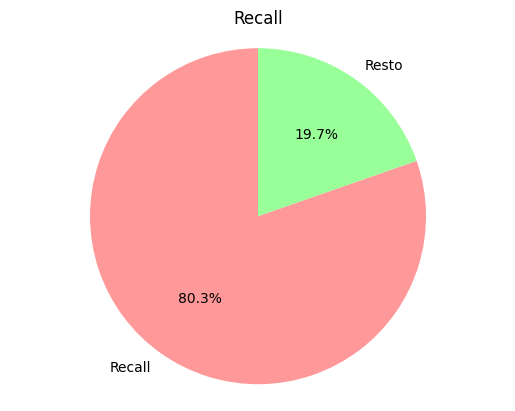

In [33]:
# Hacemos un pie plot del recall
recall = recall_score(y_test, mejor_modelo_RandomForest)

# Calcular el porcentaje de recall
porcentaje_recall = recall * 100

# Definir las etiquetas y los valores para el gráfico de pie
labels = ['Recall', 'Resto']
sizes = [porcentaje_recall, 100 - porcentaje_recall]

# Definir los colores de las porciones del gráfico
colors = ['#ff9999', '#99ff99']

# Crear el gráfico de pie
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto del gráfico
plt.axis('equal')
plt.title('Recall')

# Guardar el gráfico en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'pie_plot_recall_random_forest.png')
plt.savefig(output_file)

print(f"Gráfico guardado en: {output_file}")

In [30]:
# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, mejor_modelo_RandomForest)
cm

array([[40767, 17600],
       [ 1099,  4493]], dtype=int64)

Matriz de confusión guardada en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\matriz_confusion_Random_forest.png


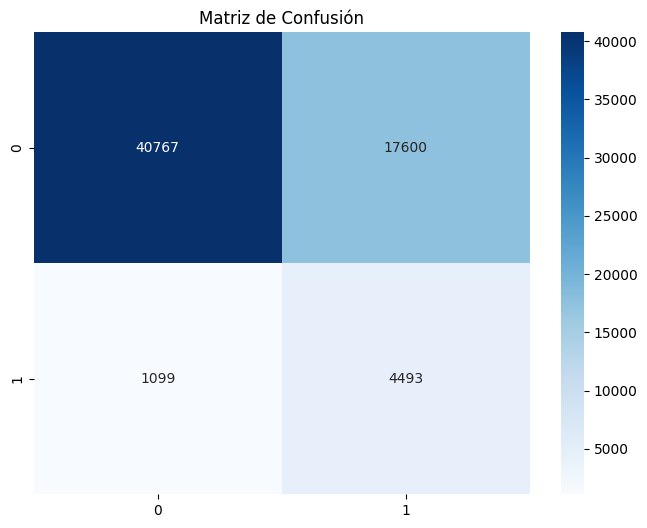

In [32]:
# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues") # con "fmt='d'" indicamos que los valores se mostrarán como enteros.

plt.title("Matriz de Confusión")

# Guardar la matriz de confusión en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'matriz_confusion_Random_forest.png')
plt.savefig(output_file)

print(f"Matriz de confusión guardada en: {output_file}")

In [8]:
# Cargamos el modelo desde el archivo
with open('../models/trained_model_decisionTree.pkl', 'rb') as file:
    mejor_modelo_decisionTree = pickle.load(file)

In [9]:
report = classification_report(y_test, mejor_modelo_decisionTree)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78     58367
           1       0.18      0.81      0.30      5592

    accuracy                           0.66     63959
   macro avg       0.58      0.73      0.54     63959
weighted avg       0.90      0.66      0.74     63959



In [24]:
# Calculamos las distintas métricas del modelo
accuracy = accuracy_score(y_test, mejor_modelo_decisionTree)
precision = precision_score(y_test, mejor_modelo_decisionTree)
recall = recall_score(y_test, mejor_modelo_decisionTree)
f1 = f1_score(y_test, mejor_modelo_decisionTree)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("Score F1:", f1)

Accuracy: 0.6626588908519521
Precisión: 0.1815428753586229
Recall: 0.8147353361945636
Score F1: 0.2969238790406674


Gráfico guardado en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\pie_plot_recall_decision_tree.png


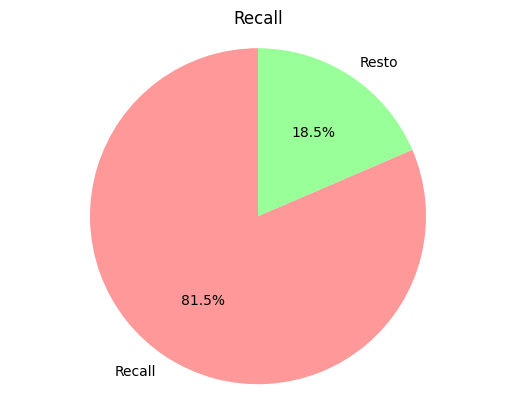

In [34]:
# Hacemos un pie plot del recall
recall = recall_score(y_test, mejor_modelo_decisionTree)

# Calcular el porcentaje de recall
porcentaje_recall = recall * 100

# Definir las etiquetas y los valores para el gráfico de pie
labels = ['Recall', 'Resto']
sizes = [porcentaje_recall, 100 - porcentaje_recall]

# Definir los colores de las porciones del gráfico
colors = ['#ff9999', '#99ff99']

# Crear el gráfico de pie
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto del gráfico
plt.axis('equal')
plt.title('Recall')

# Guardar el gráfico en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'pie_plot_recall_decision_tree.png')
plt.savefig(output_file)

print(f"Gráfico guardado en: {output_file}")

In [36]:
# Calculamos la matriz de confusión
cm_decision_tree = confusion_matrix(y_test, mejor_modelo_decisionTree)
cm_decision_tree

array([[37827, 20540],
       [ 1036,  4556]], dtype=int64)

Matriz de confusión guardada en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\matriz_confusion_decision_tree.png


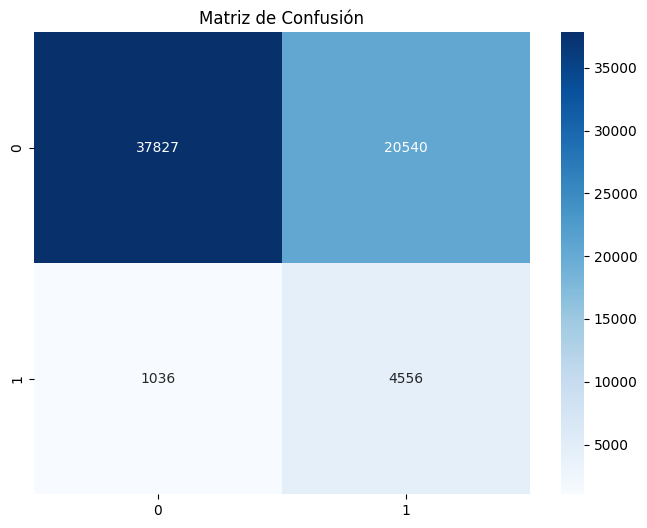

In [37]:
# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(cm_decision_tree, annot=True, fmt="d", cmap="Blues") # con "fmt='d'" indicamos que los valores se mostrarán como enteros.

plt.title("Matriz de Confusión")

# Guardar la matriz de confusión en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'matriz_confusion_decision_tree.png')
plt.savefig(output_file)

print(f"Matriz de confusión guardada en: {output_file}")

In [10]:
# Cargamos el modelo desde el archivo
with open('../models/trained_model_Log_Regression.pkl', 'rb') as file:
    mejor_modelo_Log_Regression = pickle.load(file)

In [11]:
report = classification_report(y_test, mejor_modelo_Log_Regression)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     58367
           1       0.19      0.77      0.31      5592

    accuracy                           0.70     63959
   macro avg       0.58      0.73      0.56     63959
weighted avg       0.90      0.70      0.76     63959



In [25]:
# Calculamos las distintas métricas del modelo
accuracy = accuracy_score(y_test, mejor_modelo_Log_Regression)
precision = precision_score(y_test, mejor_modelo_Log_Regression)
recall = recall_score(y_test, mejor_modelo_Log_Regression)
f1 = f1_score(y_test, mejor_modelo_Log_Regression)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("Score F1:", f1)

Accuracy: 0.6957425850935756
Precisión: 0.19195912927587738
Recall: 0.7727110157367668
Score F1: 0.30752259625649414


Gráfico guardado en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\pie_plot_recall_log_regression.png


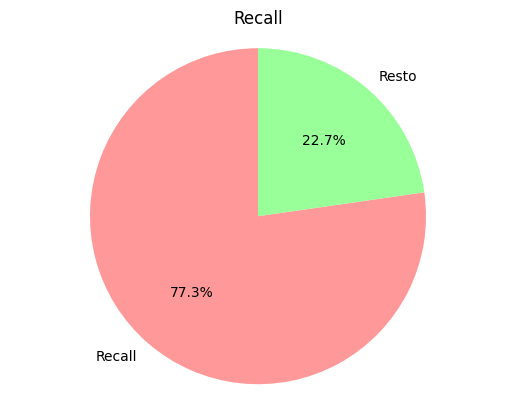

In [38]:
# Hacemos un pie plot del recall
recall = recall_score(y_test, mejor_modelo_Log_Regression)

# Calcular el porcentaje de recall
porcentaje_recall = recall * 100

# Definir las etiquetas y los valores para el gráfico de pie
labels = ['Recall', 'Resto']
sizes = [porcentaje_recall, 100 - porcentaje_recall]

# Definir los colores de las porciones del gráfico
colors = ['#ff9999', '#99ff99']

# Crear el gráfico de pie
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto del gráfico
plt.axis('equal')
plt.title('Recall')

# Guardar el gráfico en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'pie_plot_recall_log_regression.png')
plt.savefig(output_file)

print(f"Gráfico guardado en: {output_file}")

In [39]:
# Calculamos la matriz de confusión
cm_log_regression = confusion_matrix(y_test, mejor_modelo_Log_Regression)
cm_log_regression

array([[40178, 18189],
       [ 1271,  4321]], dtype=int64)

Matriz de confusión guardada en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\matriz_confusion_log_regression.png


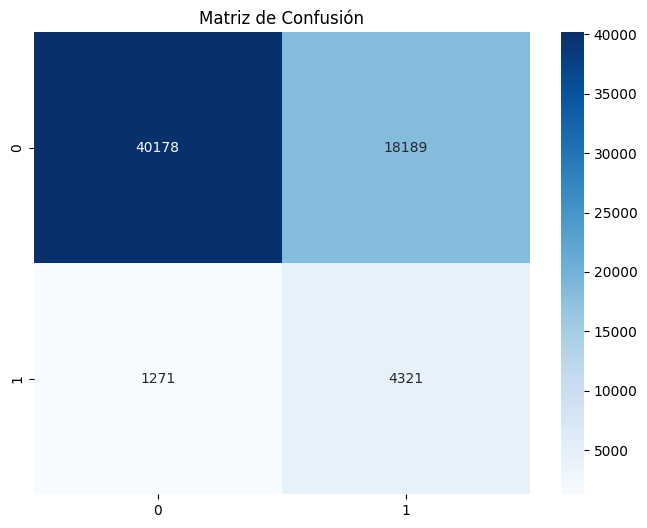

In [40]:
# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(cm_log_regression, annot=True, fmt="d", cmap="Blues") # con "fmt='d'" indicamos que los valores se mostrarán como enteros.

plt.title("Matriz de Confusión")

# Guardar la matriz de confusión en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'matriz_confusion_log_regression.png')
plt.savefig(output_file)

print(f"Matriz de confusión guardada en: {output_file}")

In [12]:
# Cargamos el modelo desde el archivo
with open('../models/trained_model_NaiveBayes.pkl', 'rb') as file:
    mejor_modelo_NaiveBayes = pickle.load(file)

In [13]:
report = classification_report(y_test, mejor_modelo_NaiveBayes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.92     58367
           1       0.29      0.38      0.33      5592

    accuracy                           0.86     63959
   macro avg       0.61      0.65      0.63     63959
weighted avg       0.88      0.86      0.87     63959



In [26]:
# Calculamos las distintas métricas del modelo
accuracy = accuracy_score(y_test, mejor_modelo_NaiveBayes)
precision = precision_score(y_test, mejor_modelo_NaiveBayes)
recall = recall_score(y_test, mejor_modelo_NaiveBayes)
f1 = f1_score(y_test, mejor_modelo_NaiveBayes)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("Score F1:", f1)

Accuracy: 0.8645694898294219
Precisión: 0.2900711159737418
Recall: 0.3792918454935622
Score F1: 0.328735275883447


Gráfico guardado en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\pie_plot_recall_naive_bayes.png


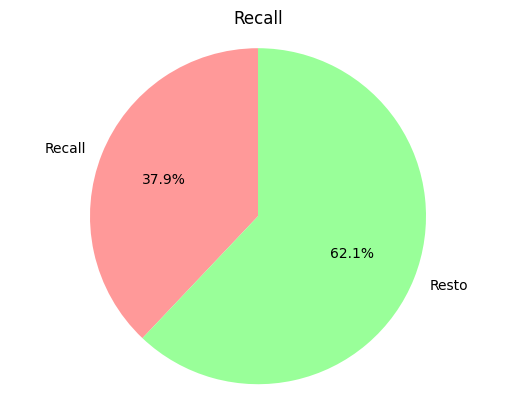

In [41]:
# Hacemos un pie plot del recall
recall = recall_score(y_test, mejor_modelo_NaiveBayes)

# Calcular el porcentaje de recall
porcentaje_recall = recall * 100

# Definir las etiquetas y los valores para el gráfico de pie
labels = ['Recall', 'Resto']
sizes = [porcentaje_recall, 100 - porcentaje_recall]

# Definir los colores de las porciones del gráfico
colors = ['#ff9999', '#99ff99']

# Crear el gráfico de pie
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto del gráfico
plt.axis('equal')
plt.title('Recall')

# Guardar el gráfico en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'pie_plot_recall_naive_bayes.png')
plt.savefig(output_file)

print(f"Gráfico guardado en: {output_file}")

In [42]:
# Calculamos la matriz de confusión
cm_naive_bayes = confusion_matrix(y_test, mejor_modelo_NaiveBayes)
cm_naive_bayes

array([[53176,  5191],
       [ 3471,  2121]], dtype=int64)

Matriz de confusión guardada en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\matriz_confusion_naive_bayes.png


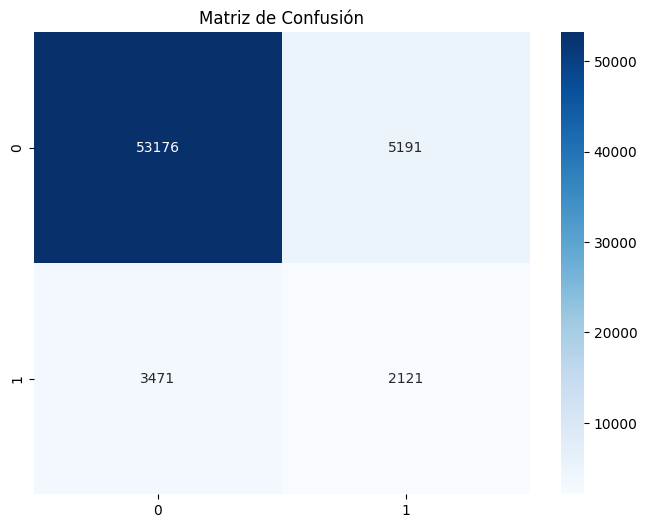

In [44]:
# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(cm_naive_bayes, annot=True, fmt="d", cmap="Blues") # con "fmt='d'" indicamos que los valores se mostrarán como enteros.

plt.title("Matriz de Confusión")

# Guardar la matriz de confusión en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'matriz_confusion_naive_bayes.png')
plt.savefig(output_file)

print(f"Matriz de confusión guardada en: {output_file}")

In [14]:
# Cargamos el modelo desde el archivo
with open('../models/trained_model_XGB_Classifiert.pkl', 'rb') as file:
    mejor_modelo_XGB_Classifier = pickle.load(file)

In [15]:
report = classification_report(y_test, mejor_modelo_XGB_Classifier)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     58367
           1       0.53      0.06      0.10      5592

    accuracy                           0.91     63959
   macro avg       0.72      0.53      0.53     63959
weighted avg       0.88      0.91      0.88     63959



In [27]:
# Calculamos las distintas métricas del modelo
accuracy = accuracy_score(y_test, mejor_modelo_XGB_Classifier)
precision = precision_score(y_test, mejor_modelo_XGB_Classifier)
recall = recall_score(y_test, mejor_modelo_XGB_Classifier)
f1 = f1_score(y_test, mejor_modelo_XGB_Classifier)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("Score F1:", f1)

Accuracy: 0.9131162150752826
Precisión: 0.5287356321839081
Recall: 0.057582260371959945
Score F1: 0.10385421706176425


Gráfico guardado en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\pie_plot_recall_xgb_classifier.png


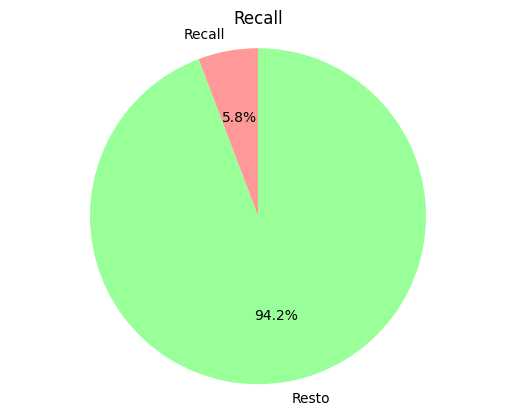

In [45]:
# Hacemos un pie plot del recall
recall = recall_score(y_test, mejor_modelo_XGB_Classifier)

# Calcular el porcentaje de recall
porcentaje_recall = recall * 100

# Definir las etiquetas y los valores para el gráfico de pie
labels = ['Recall', 'Resto']
sizes = [porcentaje_recall, 100 - porcentaje_recall]

# Definir los colores de las porciones del gráfico
colors = ['#ff9999', '#99ff99']

# Crear el gráfico de pie
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto del gráfico
plt.axis('equal')
plt.title('Recall')

# Guardar el gráfico en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'pie_plot_recall_xgb_classifier.png')
plt.savefig(output_file)

print(f"Gráfico guardado en: {output_file}")

In [46]:
# Calculamos la matriz de confusión
cm_xgb_classifier = confusion_matrix(y_test, mejor_modelo_XGB_Classifier)
cm_xgb_classifier

array([[58080,   287],
       [ 5270,   322]], dtype=int64)

Matriz de confusión guardada en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\matriz_confusion_xgb_classifier.png


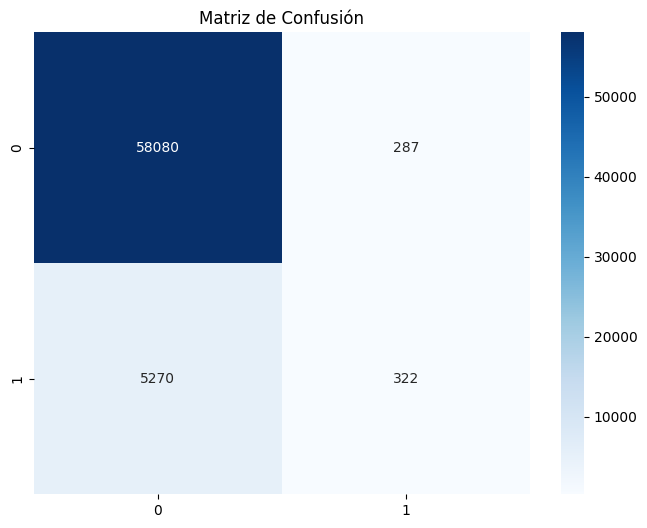

In [47]:
# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(cm_xgb_classifier, annot=True, fmt="d", cmap="Blues") # con "fmt='d'" indicamos que los valores se mostrarán como enteros.

plt.title("Matriz de Confusión")

# Guardar la matriz de confusión en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'matriz_confusion_xgb_classifier.png')
plt.savefig(output_file)

print(f"Matriz de confusión guardada en: {output_file}")

In [16]:
# Cargamos el modelo desde el archivo
with open('../models/trained_model_PCA.pkl', 'rb') as file:
    mejor_modelo_PCA = pickle.load(file)

In [17]:
report = classification_report(y_test, mejor_modelo_PCA)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     58367
           1       0.21      0.71      0.33      5592

    accuracy                           0.75     63959
   macro avg       0.59      0.73      0.59     63959
weighted avg       0.90      0.75      0.80     63959



In [28]:
# Calculamos las distintas métricas del modelo
accuracy = accuracy_score(y_test, mejor_modelo_PCA)
precision = precision_score(y_test, mejor_modelo_PCA)
recall = recall_score(y_test, mejor_modelo_PCA)
f1 = f1_score(y_test, mejor_modelo_PCA)

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("Score F1:", f1)

Accuracy: 0.745446301536922
Precisión: 0.21276938786478208
Recall: 0.7079756795422032
Score F1: 0.32720360345468824


Gráfico guardado en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\pie_plot_recall_pca.png


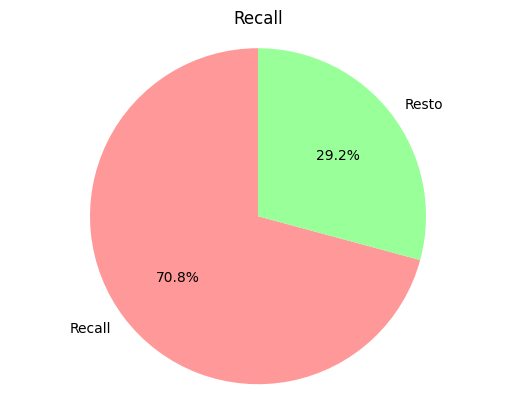

In [48]:
# Hacemos un pie plot del recall
recall = recall_score(y_test, mejor_modelo_PCA)

# Calcular el porcentaje de recall
porcentaje_recall = recall * 100

# Definir las etiquetas y los valores para el gráfico de pie
labels = ['Recall', 'Resto']
sizes = [porcentaje_recall, 100 - porcentaje_recall]

# Definir los colores de las porciones del gráfico
colors = ['#ff9999', '#99ff99']

# Crear el gráfico de pie
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Ajustar el aspecto del gráfico
plt.axis('equal')
plt.title('Recall')

# Guardar el gráfico en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'pie_plot_recall_pca.png')
plt.savefig(output_file)

print(f"Gráfico guardado en: {output_file}")

In [49]:
# Calculamos la matriz de confusión
cm_pca = confusion_matrix(y_test, mejor_modelo_PCA)
cm_pca

array([[43719, 14648],
       [ 1633,  3959]], dtype=int64)

Matriz de confusión guardada en: c:\Users\alexm\OneDrive\Escritorio\CURSO DATA SCIENCE BOOTCAMP\PROYECTO-MACHINE-LEARNING\notebooks\..\docs\imagenes\matriz_confusion_pca.png


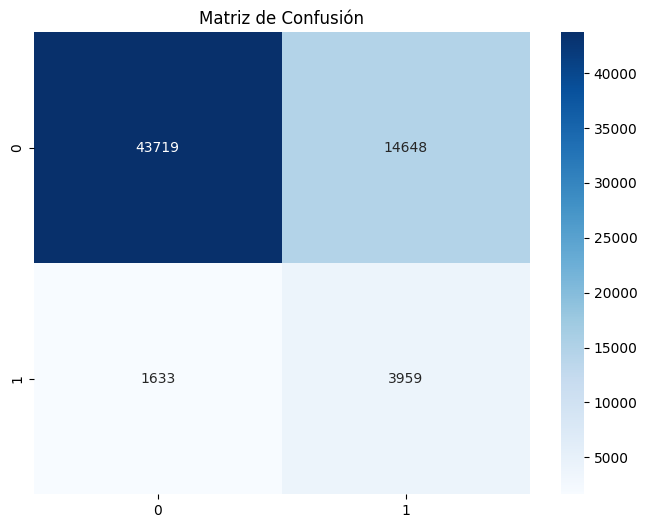

In [50]:
# Visualizamos la matriz de confusión
plt.figure(figsize=(8, 6))

# Mapa de calor
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Blues") # con "fmt='d'" indicamos que los valores se mostrarán como enteros.

plt.title("Matriz de Confusión")

# Guardar la matriz de confusión en el directorio actual
current_dir = os.getcwd()
output_file = os.path.join(current_dir, '..', 'docs', 'imagenes', 'matriz_confusion_pca.png')
plt.savefig(output_file)

print(f"Matriz de confusión guardada en: {output_file}")

In [54]:
# Unimos y creamos un nuevo dataFrame con los resultados para compararlos mejor

report_random_forest = classification_report(y_test, mejor_modelo_RandomForest, output_dict=True)
report_decision_tree = classification_report(y_test, mejor_modelo_decisionTree, output_dict=True)
report_log_regression = classification_report(y_test, mejor_modelo_Log_Regression, output_dict=True)
report_naive_bayes = classification_report(y_test, mejor_modelo_NaiveBayes, output_dict=True)
report_xgb_classifier = classification_report(y_test, mejor_modelo_XGB_Classifier, output_dict=True)
report_pca = classification_report(y_test, mejor_modelo_PCA, output_dict=True)

df_reports = pd.DataFrame({
    'Modelo': ['Random Forest', 'Decision Tree', 'Logistic Regression', 'Naive Bayes', 'XGB Classifier', 'PCA'],
    'Precision': [report_random_forest['1']['precision'],
                  report_decision_tree['1']['precision'],
                  report_log_regression['1']['precision'],
                  report_naive_bayes['1']['precision'],
                  report_xgb_classifier['1']['precision'],
                  report_pca['1']['precision']],
    'Recall': [report_random_forest['1']['recall'],
               report_decision_tree['1']['recall'],
               report_log_regression['1']['recall'],
               report_naive_bayes['1']['recall'],
               report_xgb_classifier['1']['recall'],
               report_pca['1']['recall']],
    'F1-Score': [report_random_forest['1']['f1-score'],
                 report_decision_tree['1']['f1-score'],
                 report_log_regression['1']['f1-score'],
                 report_naive_bayes['1']['f1-score'],
                 report_xgb_classifier['1']['f1-score'],
                 report_pca['1']['f1-score']]
})
df_reports


,Modelo,Precision,Recall,F1-Score
0,Random Forest,0.203368,0.803469,0.324580
1,Decision Tree,0.181543,0.814735,0.296924
2,Logistic Regression,0.191959,0.772711,0.307523
3,Naive Bayes,0.290071,0.379292,0.328735
4,XGB Classifier,0.528736,0.057582,0.103854
5,PCA,0.212769,0.707976,0.327204


In [55]:
# Lo guardamos en data/comparation_models_metrics
df_reports.to_csv('../data/comparation_models_metrics/informes_clasificacion.csv', index=False)


### EXPLICACIÓN

<details>
<summary>Explicación de las métricas</summary>
<p>

En el problema que se está tratando de resolver, el objetivo principal es lograr una alta recall, ya que indica la capacidad del modelo para identificar correctamente la mayoría de los casos positivos. Esto es especialmente importante en la detección de enfermedades cardíacas, donde es fundamental identificar adecuadamente a los pacientes que realmente padecen dicha enfermedad.

Si nos enfocamos en el mayor recall posible, podemos observar que los modelos de RandomForest, Decision Tree y Regresión Logística muestran valores más altos de recall para la clase "1". Estos modelos tienen la capacidad de identificar correctamente la mayoría de los casos positivos.

En contraste, los modelos de Naive Bayes y XGB Classifier presentan recalls más bajos para la clase "1", lo que indica que podrían no ser tan efectivos en la detección de casos positivos.

Considerando todas las métricas y teniendo en cuenta tu objetivo principal de maximizar el recall, el modelo de RandomForest podría ser la mejor opción, ya que tiene unas métricas en conjunto más sólidas que el resto.


</p>
</details>